In [ ]:
# required libraries
import numpy as np
import pickle
import cv2
import os
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential 
from keras.layers.normalization import BatchNormalization 
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image 
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt 

Using TensorFlow backend.


In [ ]:
# using google drive for dataset fetching
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
# image directory
image_directory = '/content/gdrive/My Drive/Custom-Train-Test(color)/color'

In [ ]:
# taking each image and converting to numpy array
def convert_image_to_array(path):
  try:
    # print(path)
    image = cv2.imread(path)
    if(image is not None):
      image = cv2.resize(image,(256,256))
      return img_to_array(image)
    else:
      return np.array([])
  except Exception as e:
    print(f"Error : {e}")
    return None

In [ ]:
# image preprocessing 
image_list = []
label_list = []
for directory in os.listdir(image_directory):
  path = os.path.join(image_directory,directory)
  for photo in os.listdir(path)[:200]:
    image_list.append(convert_image_to_array(os.path.join(path,photo)))
    label_list.append(directory)

In [ ]:
# intialization of class label
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open("label_transform.pkl","wb"))
n_classes = len(label_binarizer.classes_)

In [ ]:
# converting to gray scale
np_image_list = np.array(image_list,dtype=np.float16)/255.0

In [ ]:
# spliting data to test and train in 1:4 ratio
x_train,x_test,y_train,y_test = train_test_split(np_image_list,image_labels,test_size=0.2,random_state=42)

In [ ]:
# image datagenerator that rotates,flip,shift,zoom the image
aug = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

In [ ]:
# image parameters
height=256
width=256
depth=3

In [ ]:
# neural network
model = Sequential()
inputshape = (height,width,depth)
chandim=-1
if(K.image_data_format()=="channels_first"):
  inputshape = (depth,height,width)
  chandim=1
# layer-1
model.add(Conv2D(32,(3,3),padding="same",input_shape=inputshape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chandim))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Dropout(0.25))

# layer-2
model.add(Conv2D(64,(3,3),padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chandim))

#layer-3
model.add(Conv2D(64,(3,3),padding="same",input_shape=inputshape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chandim))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Dropout(0.25))

# layer-4
model.add(Conv2D(128,(3,3),padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chandim))

# layer-5
model.add(Conv2D(128,(3,3),padding="same",input_shape=inputshape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chandim))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Dropout(0.25))

# layer-6 ANN
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

In [ ]:
# optimization parameters
INIT_LR = 0.001
EPOCHS = 10
BS=10

In [ ]:
# model compilation
opt = Adam(lr=INIT_LR,decay=INIT_LR/EPOCHS)
model.compile(loss="binary_crossentropy",optimizer=opt,metrics=["accuracy"])
print("[INFO]  training network")

[INFO]  training network


In [ ]:
# model training with 10 epochs
history = model.fit_generator(
    aug.flow(x_train,y_train,batch_size=BS),
    validation_data = (x_test,y_test),
    steps_per_epoch=len(x_train)//BS,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/10
393/393 [==============================] - 747s 2s/step - loss: 0.1441 - accuracy: 0.9580 - val_loss: 0.4051 - val_accuracy: 0.9309
Epoch 2/10
393/393 [==============================] - 746s 2s/step - loss: 0.1413 - accuracy: 0.9581 - val_loss: 0.2104 - val_accuracy: 0.9446
Epoch 3/10
393/393 [==============================] - 741s 2s/step - loss: 0.1161 - accuracy: 0.9628 - val_loss: 0.2492 - val_accuracy: 0.9492
Epoch 4/10
393/393 [==============================] - 740s 2s/step - loss: 0.1046 - accuracy: 0.9657 - val_loss: 0.1161 - val_accuracy: 0.9641
Epoch 5/10
393/393 [==============================] - 747s 2s/step - loss: 0.0937 - accuracy: 0.9679 - val_loss: 0.6175 - val_accuracy: 0.9304
Epoch 6/10
393/393 [==============================] - 760s 2s/step - loss: 0.0853 - accuracy: 0.9704 - val_loss: 0.3366 - val_accuracy: 0.9415
Epoch 7/10
393/393 [==============================] - 742s 2s/step - loss: 0.0796 - accuracy: 0.9719 - val_loss: 0.0692 - val_accuracy: 0.9758

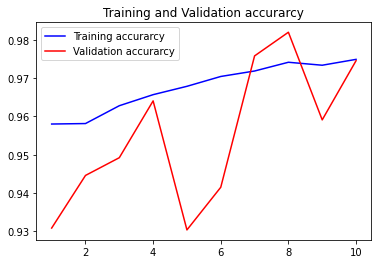

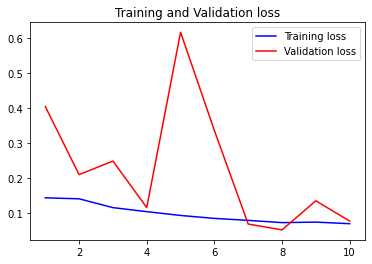

In [ ]:
# model training outcomes
acc = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

#plot against the Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()
plt.figure()

#plot against the Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
print("[INFO] Calculating model accuracy")
accurate = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {accurate[1]*100}")

[INFO] Calculating model accuracy
985/985 [==============================] - 49s 50ms/step
Test Accuracy: 97.4538266658783


In [ ]:
# predicting for the disease for single image
x = os.path.join(image_directory, "Tomato___Bacterial_spot")
image_name = os.listdir(x)[1]
image_loc = os.path.join(x,image_name)
image = convert_image_to_array(image_loc)
image = np.array(image,dtype=np.float16)/255.0
image = np.expand_dims(image,axis=0)
op = model.predict(image)
sorting = (-op).argsort()
your_classes = label_binarizer.classes_
sorted_ = sorting[0][:1]
for value in sorted_:
    predicted_label = your_classes[value]
    print(predicted_label)

Apple___Cedar_apple_rust
